# SHAP Explanations for DistilBERT

This notebook reuses the helper utilities in `src.analysis.shap_utils` to load text samples, compute SHAP values, and visualize the most influential tokens for the fine-tuned classifier.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
PROJECT_ROOT

PosixPath('/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction')

In [2]:
import matplotlib.pyplot as plt
import shap

from src.analysis.shap_utils import (
    ShapConfig,
    aggregate_token_importance,
    build_text_classifier,
    compute_shap_values,
    load_test_texts,
    summarize_examples,
)


/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cfg = ShapConfig(
    checkpoint_path=Path("models/distilbert-debug"),
    num_samples=320,
    data_limit=50000,
    sample_seed=42,
    test_ratio=0.2,
)
cfg

ShapConfig(checkpoint_path=PosixPath('models/distilbert-debug'), num_samples=320, data_limit=50000, sample_seed=42, test_ratio=0.2, algorithm='partition', class_ratio=0.5)

In [4]:
texts, labels = load_test_texts(cfg, return_labels=True)
clf = build_text_classifier(cfg.checkpoint_path)
shap_values = compute_shap_values(clf, texts, algorithm=cfg.algorithm)
len(texts)


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer:   3%|▎         | 9/320 [00:15<05:24,  1.04s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (820 > 512). Running this sequence through the model will result in indexing errors
PartitionExplainer explainer: 321it [07:47,  1.48s/it]                         


320

In [6]:
token_importance = aggregate_token_importance(shap_values, top_k=20)
token_importance

,token,count,mean_score,mean_abs_score
0,Published,1,-0.225786,0.225786
1,Comments,1,-0.163607,0.163607
2,Identify,1,-0.157925,0.157925
3,abstract,1,-0.103017,0.103017
4,…,3,-0.092132,0.092132
5,aims,3,-0.088544,0.088544
6,incredibly,1,-0.088256,0.088256
7,Writing,1,-0.087279,0.087279
8,expressing,1,-0.081999,0.081999
9,stating,1,-0.068203,0.068203


In [7]:
example_summary = summarize_examples(clf, shap_values, texts, top_k=5, true_labels=labels)
example_summary.head()


,example,predicted_label,confidence,top_tokens,text_snippet,true_label,true_label_is_ai,prediction_is_ai,prediction_correct,truth_annotation
0,1,LABEL_1,0.999113,"s (-0.001), ' (-0.001), It (-0.001), our (-0.0...",It's time I broke this\n\nto the public. The w...,AI,True,True,True,Truth: AI
1,2,LABEL_1,0.950896,"conditions (-0.020), portrayed (-0.020), the (...",We lived through the depression and related to...,Human,False,True,False,Truth: Human
2,3,LABEL_1,0.975873,"The (-0.065), including (-0.065), Overall (-0....",A low-budget horror film produced by Evil Dead...,Human,False,True,False,Truth: Human
3,4,LABEL_1,0.999066,"concern (-0.040), our (-0.034), "" (-0.030), ch...",The UK manufacturing sector will continue to f...,Human,False,True,False,Truth: Human
4,5,LABEL_1,0.999110,"Mr (+0.003), also (-0.003), looking (-0.002), ...","If people in the UK don't have broadband, they...",AI,True,True,True,Truth: AI


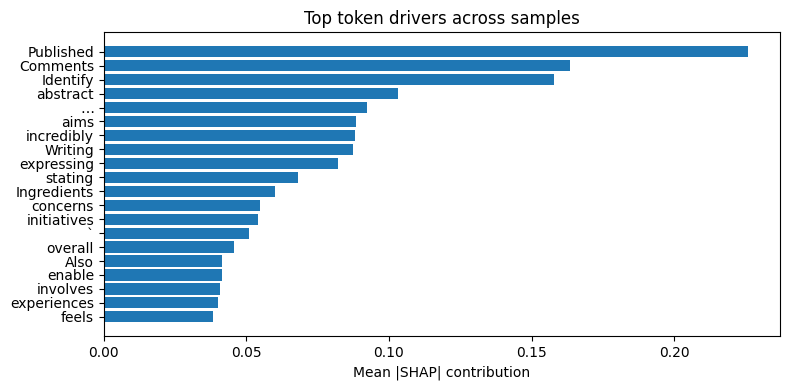

In [8]:
if not token_importance.empty:
    plt.figure(figsize=(8, 4))
    plt.barh(token_importance["token"][::-1], token_importance["mean_abs_score"][::-1])
    plt.xlabel("Mean |SHAP| contribution")
    plt.title("Top token drivers across samples")
    plt.tight_layout()
    plt.show()
else:
    print("No aggregated token importance available.")

In [9]:
truth = 'AI, 1' if labels[0] == 1 else 'Human, 0'
print(f'Ground truth: {truth}')
prediction = clf(texts[0], top_k=1)[0]
print(f"Predicted class: {prediction['label']} ({prediction['score']:.3f})")
shap.plots.text(shap_values[0])


Ground truth: AI, 1
Predicted class: LABEL_1 (0.999)


In [10]:
sample_idx = 6  # Change this index to view different examples
truth = 'AI, 1' if labels[sample_idx] == 1 else 'Human, 0'
print(f'Ground truth: {truth}')
prediction = clf(texts[sample_idx], top_k=1)[0]
print(f"Predicted class: {prediction['label']} ({prediction['score']:.3f})")
shap.plots.text(shap_values[sample_idx])


Ground truth: AI, 1
Predicted class: LABEL_1 (0.999)
